# Total Variation Image Diffusion Registration
#### **Theory and algorithm from:** L. I. Rudin and S. Osher, "Total variation based image restoration with free local constraints," *Proceedings of 1st International Conference on Image Processing*, Austin, TX, USA, 1994, pp. 31-35 vol.1, doi: 10.1109/ICIP.1994.413269.

#### **Notebook by:** Daniel Antonio Brito Pacheco, BSc

Given a reference image $R$ and template image $T$, image registration looks to find a local or global transformation $u(x,y) = \big(u_1(x,y), u_2(x,y)\big)$ such that:
$$
T\big((x,y)-u(x,y)\big) = R(x,y).
$$
To this end, one must minimize the functional
$$
\mathcal{J}(u) = \mathcal{D}(R,T,u) + \lambda\mathcal{L}(u)\,, \tag{1}
$$
where
$$
\mathcal{D}(R,T,u) = \frac{1}{2}\int_\Omega\big[ T\big((x,y)-u(x,y)\big) - R(x,y) \big]^2\,dx\,dy
$$
and, since this notebook is about diffusion registration:
$$
\mathcal{L}(u) = \frac{1}{2}\int_\Omega||\nabla u_1(x,y)||^2 + ||\nabla u_2(x,y)||^2 \, dx\,dy.
$$
The Euler-Lagrange equation for (1) ends up being:
$$
f(x,y,u(x,y)) + \lambda\Delta u(x,y) = 0\,, \tag{2}
$$
where $f(x,y, u(x,y)) = \big(R(x,y)-T((x,y)-u(x,y))\big)\cdot\nabla T((x,y)-u(x,y))$. \\
The above equations yield the following gradient descent solution:
$$
\frac{\partial u}{\partial t} = f(x,y, u(x,y)) + \lambda\Delta u(x,y) 
$$

In [17]:
# First, import all necessary libraries

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import laplace
from scipy import signal

In [18]:
# This function defines the gaussian convolution operation of an image using the submodule signal from scipy
# the gaussian blur is applied to make a smoother image. This helps in processing the image.

def convolve(u, filter_size=50):
    t = np.linspace(-10, 10, filter_size)
    bump = np.exp(-0.1*t**2)
    bump /= np.trapz(bump) # normalize the integral to 1
    # make a 2-D kernel out of it
    kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
    # mode='same' is there to enforce the same output shape as input arrays
    img3 = signal.fftconvolve(u, kernel, mode='same')
    return(img3)

In [19]:
# This function calculates the laplacian of u which first appears in equation (2)

def laplacian(U1, U2):
    lap = []
    for U in [U1, U2]:
        Ux, Uy = np.gradient(U)
        Uxx = np.gradient(Ux)[0]
        Uyy = np.gradient(Uy)[0]
        lap.append(Uxx + Uyy)
    return(tuple(lap))

In [20]:
# Calculates the function f

def f(x, y, U1, U2, R, T):
    M,N = R.shape
    
    Tx, Ty = np.gradient(T)
    u1, u2 = U1[x,y], U2[x,y]
    
    if (x-round(u1) < 0) or (x-round(u1) >= M) or (y-round(u2) < 0) or (y-round(u2) >= N):
        # If "coming" from outside the image domain, we simply write a 0
        T_xy = 0 
    else:
        T_xy = T[x-round(u1), y-round(u2)]
    
    output_part1 = R[x,y] - T_xy    # This is a number
    output_part2 = np.array([ Tx[x,y], Ty[x,y] ])   # This is an array of two numbers
    output = output_part1*output_part2
    return(output)

In [21]:
# Performs Gradient Descent

def grad_descent(N_iter, lamb, alpha, R, T):
    M, N = R.shape
    U1, U2 = np.zeros((M,N)), np.zeros((M,N))
    norm_history1, norm_history2 = [], []
    for i in range(N_iter):
        A1, A2 = laplacian(U1, U2)
        for x in range(M):
            for y in range(N):
                f1, f2 = f(x, y, U1, U2, R, T)
                gradU1, gradU2 = (f1 + lamb*A1[x,y]), (f2 + lamb*A2[x,y])
                U1[x,y] = U1[x,y] - alpha * gradU1
                U2[x,y] = U2[x,y] - alpha * gradU2
                
        if i % 100 == 0:
            #print('Iteration', i)
            normU1 = np.linalg.norm(gradU1)
            normU2 = np.linalg.norm(gradU2)
            print('Iteration = ', i, ' U1 Gradient Norm = ', normU1, ' U2 Gradient Norm = ', normU2)
            norm_history1.append(normU1)
            norm_history2.append(normU2)
    return(U1, U2, norm_history1, norm_history2)

In [22]:
# This function moves R once u has been calculated using gradient descent
# With this we can verify that the transformation we found is correct

def moveReferenceImage(R, U1, U2):
    M, N = R.shape
    new_image = np.zeros((M,N))
    for x in range(M):
        for y in range(N):
            u1, u2 = U1[x,y], U2[x,y]
            if (x+round(u1) < 0) or (x+round(u1) >= M) or (y+round(u2) < 0) or (y+round(u2) >= N):
                # If "going" outside the image domain, we simply write a 0
                R_pixel = 0
            else:
                R_pixel = R[x+round(u1), y+round(u2)]
            new_image[x,y] = R_pixel
    return(new_image)

[]

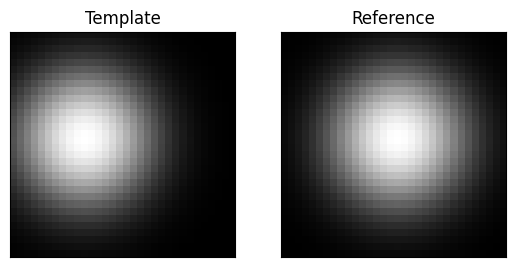

In [47]:
# Read the images (small images are preferred)
temp = convolve(np.array( Image.open("ref_small.png").convert('L'), dtype = 'int16' ), filter_size=45)
ref = convolve(np.array( Image.open("temp_small.png").convert('L'), dtype = 'int16' ), filter_size=45)

# Plot the images
fig, axs = plt.subplots(1,2)
axs[0].imshow(temp,cmap='gray')
axs[0].set_title('Template')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(ref,cmap='gray')
axs[1].set_title('Reference')
axs[1].set_xticks([])
axs[1].set_yticks([])

In [57]:
# Choose parameters

N_iter = 1201
lr = 0.00005
lamb = 10

# Perform Gradient Descent
U1, U2, norm_history1, norm_history2 = grad_descent(N_iter, lamb, lr, ref, temp)

Iteration =  0  U1 Gradient Norm =  0.002046627516743104  U2 Gradient Norm =  0.0028580888967114667
Iteration =  100  U1 Gradient Norm =  0.0017954152806102784  U2 Gradient Norm =  0.0024817229282890906
Iteration =  200  U1 Gradient Norm =  0.0015610758284828508  U2 Gradient Norm =  0.0021316747278718657
Iteration =  300  U1 Gradient Norm =  0.0013430404559724258  U2 Gradient Norm =  0.0018066414451410177
Iteration =  400  U1 Gradient Norm =  0.0011407399092765377  U2 Gradient Norm =  0.0015053416715001657
Iteration =  500  U1 Gradient Norm =  0.0009536049833565529  U2 Gradient Norm =  0.0012265161294945787
Iteration =  600  U1 Gradient Norm =  0.0007810671364205872  U2 Gradient Norm =  0.000968928372306636
Iteration =  700  U1 Gradient Norm =  0.0006225590999954528  U2 Gradient Norm =  0.0007313654669328946
Iteration =  800  U1 Gradient Norm =  0.0004775153794047515  U2 Gradient Norm =  0.0005126384791906496
Iteration =  900  U1 Gradient Norm =  0.00034537247793322906  U2 Gradient Nor

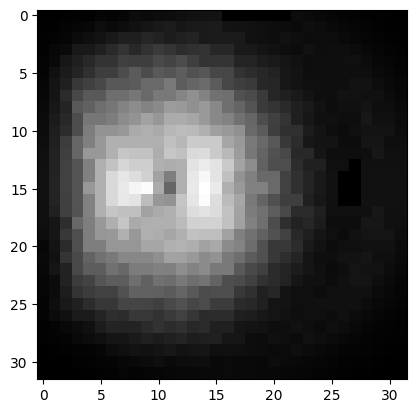

In [58]:
# Make and show transformed R

M = moveReferenceImage(ref, U1, U2)
plt.imshow(M, cmap='gray')

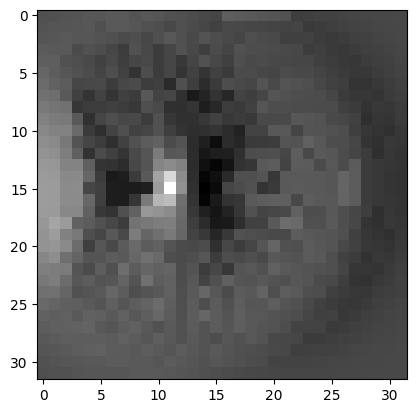

In [62]:
# Show difference between template and new image
# Dark spots are where the new image is brighter than the template
# Bright spots are there the template is brighter than the new image

plt.imshow(T-M, cmap='gray')

Text(0.5, 1.0, 'U2 gradient')

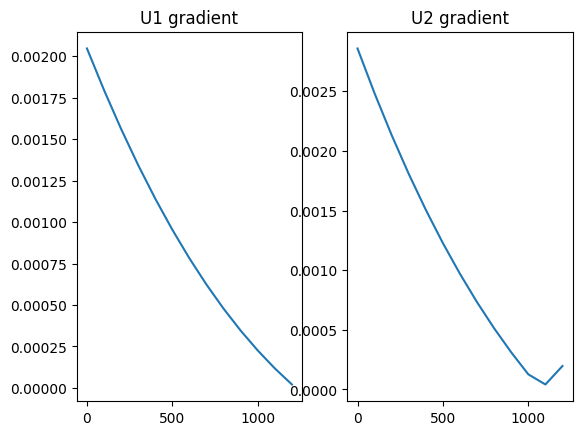

In [63]:
# Show the gradient histories

X = np.linspace(0,N_iter,len(norm_history1))

fig, axs = plt.subplots(1,2)
axs[0].plot(X, norm_history1)
axs[0].set_title('U1 gradient')

axs[1].plot(X, norm_history2)
axs[1].set_title('U2 gradient')